## Libraries

In [1]:
from neuralNetwork.neuralnetwork import Network as net
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
%matplotlib inline

## Load Data

In [2]:
path = r'./../data/'
tf   = pd.read_csv(path+'train_feautures.csv') # train features
tt   = pd.read_csv(path+'train_targets.csv')   # train targets
tef  = pd.read_csv(path+'test_feautures.csv')  # test features
teft = pd.read_csv(path+'test_targets.csv')    # test targets
vf   = pd.read_csv(path+'val_feautures.csv')   # val features
vt   = pd.read_csv(path+'val_targets.csv')     # validation targets

In [3]:
tf.head(1)

,dteday,temp,yr_0,yr_1,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weathersit_4,windspeed1,hum1_0,hum1_1,hum1_2,hum1_3,windspeed1_0,windspeed1_1,windspeed1_2,windspeed1_3
0,2011-01-01,-1.334648,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [4]:
tf = tf.drop('dteday',axis=1)
vf = vf.drop('dteday',axis=1)
tef = tef.drop('dteday',axis=1)

## Loss function

In [5]:
def mse(y, Y):
    return np.mean((y-Y)**2)

## Initial Network Parameters

In [50]:
n_iter        = 5000
learning_rate = 0.1
hidden_nodes  = 32
output_nodes  = 1  # regression problem single variable to predict
input_nodes   = tf.shape[1]
batch_size    = 512
print(input_nodes)

28


## instantiate network

In [51]:
network = net(hidden_nodes, input_nodes, output_nodes, learning_rate)

number of input features = 28
number of parameters to be trained = 896
number of parameters to be trained = 32
total number of parameters = 928


In [52]:
tf.values.shape,tt.values.shape

((15435, 28), (15435, 3))

## Train Network

In [53]:
losses = {'train':[], 'validation':[]}

for k in range(n_iter):
    # train on batches
    batch = np.random.choice(tf.index, size=batch_size)
    X, y = tf.iloc[batch].values, tt.iloc[batch]['cnt']
    network.train(X,y)
    train_loss =  mse(network.forward_run(tf).T, tt['cnt'].values)
    val_loss = mse(network.forward_run(vf).T, vt['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 *k/float(n_iter)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.902 ... Validation loss: 1.482

## Plot Validation - Train

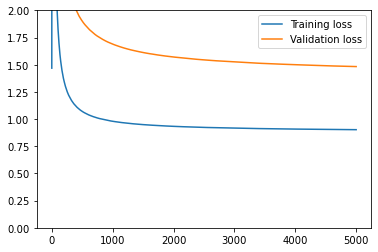

In [54]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim([0,2])

## Plot Test

In [55]:
rides = pd.read_csv(path+'hour.csv')
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']

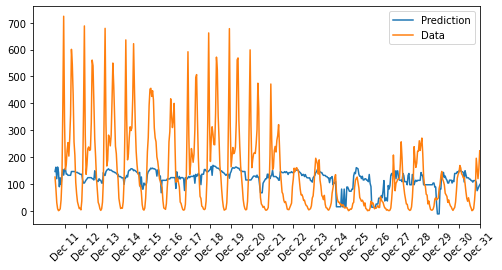

In [56]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.forward_run(tef).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((teft['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)